<h1>Content-Based Recommendations Engine</h1>

In this section, we set up the foundation for our content-based movie recommender using weighted matrix and kmeans clustering to evaluate the accuracy of the predicted movies. Our system takes in a list of movies and their ratings from the user and will recommend movies that are similar in genres to the liked movies. 


<h4>Step 1: Importing the necessary libraries</h4>

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, from_json, col, explode, collect_list,concat_ws,lit
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt

<h4>Step 2: Spark Configuration/Setup</h4>

We will be using Spark to build our recommender system. Spark is a distributed computing framework that allows us to run our code on a cluster of machines. It's a great tool to use when we want to scale our code to a large dataset. We will be using the pyspark library to run our code on a local machine. We will be using the pyspark.sql library to create our dataframes, and the pyspark.ml library to build our recommender system.


In [2]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Movie Recommender") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

<h4>Step 3: Data Preparation/Loading</h4>

For our content-based recommender, we will be using `movies_metadata.csv` which movies and their features. In this section, we are preparing the data by selecting the columns that we are interested in (id,title, genres, original_title). Furthermore, we are eliminating rows which have missing values since we will not be able to make constructive comparison. 


In [3]:
spark = init_spark()
file = spark.read.csv(os.path.join("data/movies_metadata.csv"), header=True, inferSchema=True)

# Select columns we are interested in
movies_df = file.select("id", "title", "genres","original_title").distinct()
genres_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True)
])

# Convert the "genres" column to an array of structs
movies_df = movies_df.withColumn("genres", from_json(col("genres"), ArrayType(genres_schema)))

movies_df = movies_df.select("id","original_title", "title", explode(col("genres")).alias("genre")) \
               .select("id","original_title", "title", col("genre.name").alias("genre_name")) \
               .dropna()

# Group the data by id and title, and collect the genre names into a list
movies_df = movies_df.groupBy("id", "title","original_title").agg(collect_list("genre_name").alias("genres"))

# Combine the genre names into one string
movies_df = movies_df.withColumn("genres", concat_ws(",", "genres"))

<h4>Step 4: Data Modeling</h4>

For our data modeling we will follow the following step:
1. Create a matrix using input user ratings
2. Collect distinct genres 
3. Create a matrix using movies from Step 3 `movies_df`
    - Create a column for each genres
    - For each row, we add a value of 1 if the movie is part of the genre otherwise the value is 0
4. Multiply input user ratings matrix (1) with movies matrix (3) and obtain weighted genre matrix
5. Aggregate the weighted genres and normalize them to create a user profile to know which genres the user likes 
6. Mutiply the normalized user profile with the candidate movies to obtain a weighted movies matrix
7. Sum all columns to get a score for each movie
8. Recommended movies are movies with the highest score

In [4]:
def recommend_movies_weight_matrix(movies_df, moviesInput, inputRatings, numberOfRecommendation):

    # Format df so that each column is a genre
    genres = movies_df.select("genres").rdd.flatMap(lambda x: x[0].split(',')).distinct().collect()

    # Create a PySpark dataframe containing the input titles
    original_input_df = movies_df.filter(col("title").isin(moviesInput))

    for genre in genres:
        movies_df = movies_df.withColumn(genre, col("genres").contains(genre).cast("int"))
        original_input_df = original_input_df.withColumn(genre, col("genres").contains(genre).cast("int"))

    # Multiply the inputRatings with movie matrix with each matrix
    for i,movie in enumerate(moviesInput):
        rating = inputRatings[i]
        movie_input_df = movies_df.filter(col('title') == movie)
        for genre in genres:
            movie_input_df = movie_input_df.withColumn(genre, col(genre) * rating)
        movies_df = movies_df.filter(col('title') != movie).union(movie_input_df)
    
    user_input_movies_with_ratings_df = movies_df.filter(col('title').isin(moviesInput))

    # Dataframe with the sum of each column (HERE WE SHOULD ONLY ADD USER INPUT MOVIES AND NORMALIZE THE USER INPUT MOVIES)
    genre_sum_df = user_input_movies_with_ratings_df.select([_sum(genre).alias(genre) for genre in genres])
    row_values = genre_sum_df.first()

    # Sum of total
    result = 0
    for column_name in genre_sum_df.columns:
        value = row_values[column_name]
        result += value

    # Normalize each genres
    genre_sum_df_normalized = genre_sum_df.select(*[(col(genre) / result).alias(genre) for genre in genre_sum_df.columns])

    # Create a new dataframe that multiplies each genre value with the corresponding normalized value
    multiplied_df = movies_df
    input_multiplied_df = original_input_df
    for genre in genres:
        normalized_genre = genre_sum_df_normalized.select(genre).first()[0]
        multiplied_df = multiplied_df.withColumn(genre, col(genre) * normalized_genre)
        input_multiplied_df = input_multiplied_df.withColumn(genre, col(genre) * normalized_genre)
    
    # Exclude the input movies from the recommendations AND keep ids in clust
    multiplied_df = multiplied_df.filter(~col('title').isin(moviesInput))
    
    # Sum values of a row and store it in a new column called sum then show top 10
    final_weighted_matrix = multiplied_df.withColumn('sum', sum(multiplied_df[col] for col in genres))
    final_weighted_matrix = final_weighted_matrix.orderBy("sum", ascending=False).limit(numberOfRecommendation)
    # final_weighted_matrix.show(truncate=False)

    # Evaluation (compare the sum of the inputs to the sum of the suggested movies)
    # final_original_inputs_weighted_matrix = input_multiplied_df.withColumn('sum', sum(input_multiplied_df[col] for col in genres))
    # final_original_inputs_weighted_matrix = final_original_inputs_weighted_matrix.orderBy("sum", ascending=False)
    # final_original_inputs_weighted_matrix.show(truncate=False)
    
    return final_weighted_matrix



<h4>Step 5: Data Prediction</h4>

For the movie prediction, we get the input movies from the user with each movie ratings and feed them to our method from the last step `recommend_movies_weight_matrix` with the number of recommendation we want. 


In [5]:
# # Input movies and Ratings for the input movies
moviesInput = ["Brother Bear", "Toy Story", "The Dark Knight","Heat"]
ratings = [10, 9, 1, 2 ]
numberOfRecommendation = 100

# # Call the recommend_movies function
recommended_movies_weight_matrix = recommend_movies_weight_matrix(movies_df, moviesInput, ratings, numberOfRecommendation)
recommended_movies_weight_matrix.show(truncate=False)

+------+----------------------------------------+------------------------------------+-------------------------------------------------------------------------+-------+-------------------+-------------------+-------------------+---------------+-------+-------+-------+-----------+-------+-----+--------+-------------------+-------------------+---+------+-------------------+-------+-----+-------------------+------------------+
|id    |title                                   |original_title                      |genres                                                                   |Mystery|Comedy             |Action             |Adventure          |Science Fiction|Western|Fantasy|Romance|Documentary|Foreign|Music|TV Movie|Animation          |Drama              |War|Horror|Thriller           |History|Crime|Family             |sum               |
+------+----------------------------------------+------------------------------------+----------------------------------------------------------

<h4>Step 6: Model Evaluation</h4>

To evaluate the results, we use kmeans clustering with 15 clusters to divide the movies based on their genre. For each movie, we build a vector using the genres columns and use this vector for our model. We then find the cluster for the input movies and compare them to the recommended movies to see how many are in the same cluster as the input movies. 


In [6]:
def recommend_movies_kmeans(movies_df, likedMoviesInput, recommended_movies_weight_matrix, numberOfRecommendation):

    # Assume that the movies input are movies that are liked
    # Train kmean model
    # Get predictions of cluster number of movies input
    # Filter to search for recommended movies
    # Show filter

    # Format df so that each column is a genre
    genres = movies_df.select("genres").rdd.flatMap(lambda x: x[0].split(',')).distinct().collect()
    for genre in genres:
        movies_df = movies_df.withColumn(genre, col("genres").contains(genre).cast("int"))
    for movie in likedMoviesInput:
        movie_input_df = movies_df.filter(col('title') == movie)
        for genre in genres:
            movie_input_df = movie_input_df.withColumn(genre, col(genre))
        movies_df = movies_df.filter(col('title') != movie).union(movie_input_df)

    # Create feature vector
    assembler = VectorAssembler(inputCols=genres, outputCol="features")

    movies_df = assembler.transform(movies_df)

    # Format input movies as df
    user_input_movies_df = movies_df.filter(col('title').isin(likedMoviesInput))

    # Cluster movies using KMeans
    kmeans = KMeans(k=15)
    model = kmeans.fit(movies_df.select("features"))

    # Get cluster labels for all movies
    clustered = model.transform(movies_df)

    # Get cluster labels for user input movies
    user_clustered = model.transform(user_input_movies_df).withColumnRenamed("title", "user_title")
    user_predictions = user_clustered.select('prediction').rdd.flatMap(lambda x: x).collect()

    # Get recommended movies from same clusters as user input movies
    cluster_movies_df = clustered.filter(col('prediction').isin(user_predictions)).filter(~col('title').isin(moviesInput))

    # Get the cluster number for the recommended_movies from weight matrix 
    list_of_recommended_movies = recommended_movies_weight_matrix.select('id').rdd.flatMap(lambda x: x).collect()   
    recommended_movies_df = cluster_movies_df.filter(col('id').isin(list_of_recommended_movies))
    # recommended_movies_df.show(truncate=False)
 
    print("Performance metric (accuracy): " + str(recommended_movies_df.count() / numberOfRecommendation))
    return recommended_movies_df.count() / numberOfRecommendation
   

# Input movies
# liked_moviesInput =  ["Brother Bear", "Toy Story","Jumanji"]
liked_moviesInput = ["Brother Bear", "Toy Story", "The Dark Knight","Heat"]

# liked_moviesInput =  ["Brother Bear", "Toy Story", "The Dark Knight"]

# Call the recommend_movies function
recommended_movies = recommend_movies_kmeans(movies_df, liked_moviesInput, recommended_movies_weight_matrix, numberOfRecommendation)


Performance metric (accuracy): 0.99


<h4>Step 7: Model Performance</h4>

For our model performance, we evaluate the accuracy of the recommended movies for different number of recommendation. We use `recommend_movies_kmeans` with different number of recommendation to get the accuracy and plot it. Looking at the plot from the code below, we see that the more movies we want, the less accurate the movies are.


Performance metric (accuracy): 0.98
Performance metric (accuracy): 0.99
Performance metric (accuracy): 0.9666666666666667
Performance metric (accuracy): 0.95
Performance metric (accuracy): 0.96
Performance metric (accuracy): 0.9666666666666667
Performance metric (accuracy): 0.9714285714285714
Performance metric (accuracy): 0.97
Performance metric (accuracy): 0.9711111111111111
Performance metric (accuracy): 0.966
Performance metric (accuracy): 0.9036363636363637
Performance metric (accuracy): 0.865
[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
[0.98, 0.99, 0.96667, 0.95, 0.96, 0.96667, 0.97143, 0.97, 0.97111, 0.966, 0.90364, 0.865]


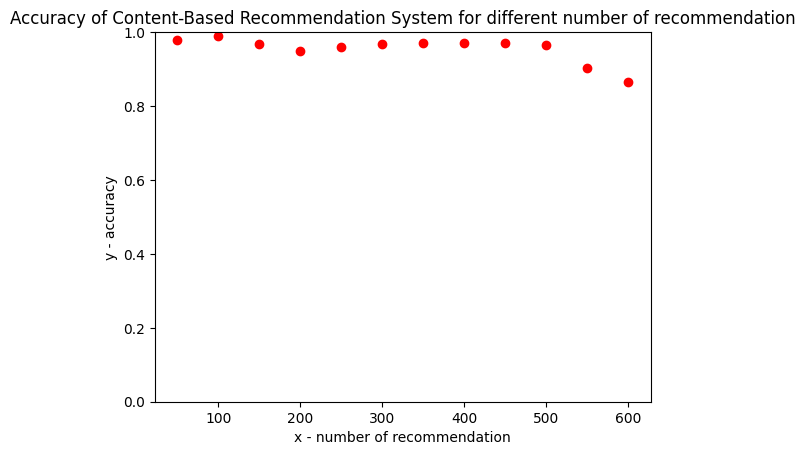

In [7]:
x_nb_recommendation = []
y_accuracy = []

for i in range(50,601,50):
    recommended_movies_weight_matrix = recommend_movies_weight_matrix(movies_df, moviesInput, ratings, i)
    temp_accuracy = recommend_movies_kmeans(movies_df, liked_moviesInput, recommended_movies_weight_matrix, i)
    x_nb_recommendation.append(i)
    y_accuracy.append(temp_accuracy)

y_accuracy = [round(num, 5) for num in y_accuracy]  

print(x_nb_recommendation)
print(y_accuracy)

plt.plot(x_nb_recommendation, y_accuracy, 'ro')
plt.xlabel('x - number of recommendation')
plt.ylabel('y - accuracy')
plt.title("Accuracy of Content-Based Recommendation System for different number of recommendation")
plt.ylim([0, 1])

plt.show()



<h4> Step 8: The end</h4>

In [ ]:
spark.stop()